In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy


sc.set_figure_params(figsize=(4, 4))

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# SOMATIC early

### Read in dataset

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [4]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

## Annotate cells

In [5]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Add old cluster subname
meta = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/old/FCA-gonads_scVI_supporting_1stEarly.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

cell_annot = meta['celltype'].to_dict()
adata.obs['celltype_v2'] = adata.obs_names.map(cell_annot).astype('category')

In [7]:
adata.obs['lineage'].values.describe()

counts     freqs
categories                         
CoelEpi             24458  0.061675
Doublet              5821  0.014679
Endothelial         14484  0.036524
Epithelial          20222  0.050993
Erythroid            1371  0.003457
FetalLeydig          2426  0.006118
GermCells           14516  0.036604
Immune               5533  0.013952
Mesenchymal_GATA2   84229  0.212396
Mesenchymal_LHX9    66077  0.166623
Neural               3783  0.009539
PV                  12679  0.031972
SMCs                 3044  0.007676
Sertoli             34969  0.088180
Supporting          28124  0.070919
cont                 1432  0.003611
lowQC               34516  0.087037
preGranulosa        38881  0.098044

In [8]:
adata = adata[[ not pd.isna(i) for i in adata.obs.lineage ]]
adata = adata[[i not in ['lowQC'] for i in adata.obs.lineage]]
adata = adata[[i in ['Supporting', 'Sertoli', 'CoelEpi', 'Mesenchymal_LHX9', 'FetalLeydig', 'preGranulosa'] for i in adata.obs.lineage]]
adata = adata[[float(i) < 8.6 for i in adata.obs.PCW]]
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(17458, 28820)

In [9]:
adata.obs['lineage'].values.describe()

counts     freqs
categories                        
CoelEpi             9457  0.541700
Mesenchymal_LHX9    2674  0.153168
Sertoli               18  0.001031
Supporting          5226  0.299347
preGranulosa          83  0.004754

In [10]:
adata.obs['celltype_v2'].values.describe()

counts     freqs
categories                            
CoelEpi_GATA2           1877  0.107515
CoelEpi_LHX9             482  0.027609
CoelEpi_LHX9_cycling    2370  0.135754
Doublet                   68  0.003895
Gi                       905  0.051839
Sertoli                   86  0.004926
lowQC                    150  0.008592
preGC_I                  367  0.021022
sKITLG                  1807  0.103506
sLGR5                    804  0.046053
sPAX8e                   908  0.052011
NaN                     7634  0.437278

In [11]:
sc.pp.filter_genes(adata, min_counts=5)

Trying to set attribute `.var` of view, copying.
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Identify HVGs

In [12]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3"
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [13]:
# subset object for latter
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Load latent space scVI

In [15]:
X_scVI = pd.read_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_somaticEarly.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Clustering

In [16]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2, spread=1.5)

In [17]:
sc.pl.umap(
    adata,
    color=["sex", "lineage_v2"], 
    frameon=True, ncols = 1, wspace = 0.3
)

In [18]:
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(
    adata,
    color=['leiden', 'celltype_v2', 'scrublet_score', 'sex'], legend_loc='on data',legend_fontsize=8,
    frameon=True,  wspace = 0.3
)

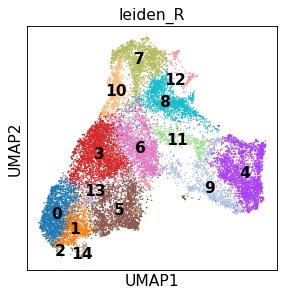

In [19]:
# isolate preGC_I
sc.tl.leiden(adata, resolution=0.35, restrict_to=('leiden', ['0']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

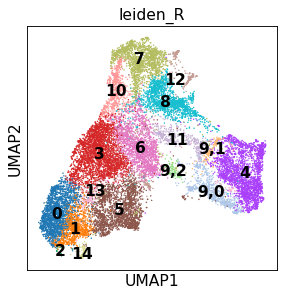

In [20]:
# isolate doublets
sc.tl.leiden(adata, resolution=0.15, restrict_to=('leiden', ['9']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

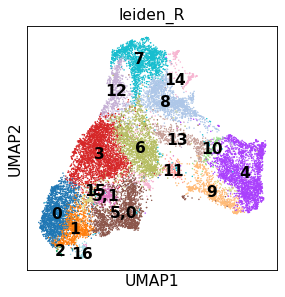

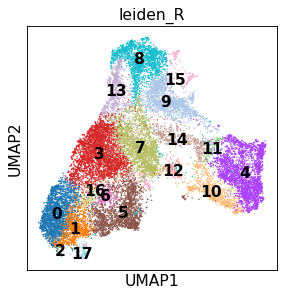

In [40]:
# clean sPAX8 from lowQC
sc.tl.leiden(adata, resolution=0.2, restrict_to=('leiden', ['5']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

## Annotate clusters

In [41]:
# identify lowQC
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden_R', rotation=90)

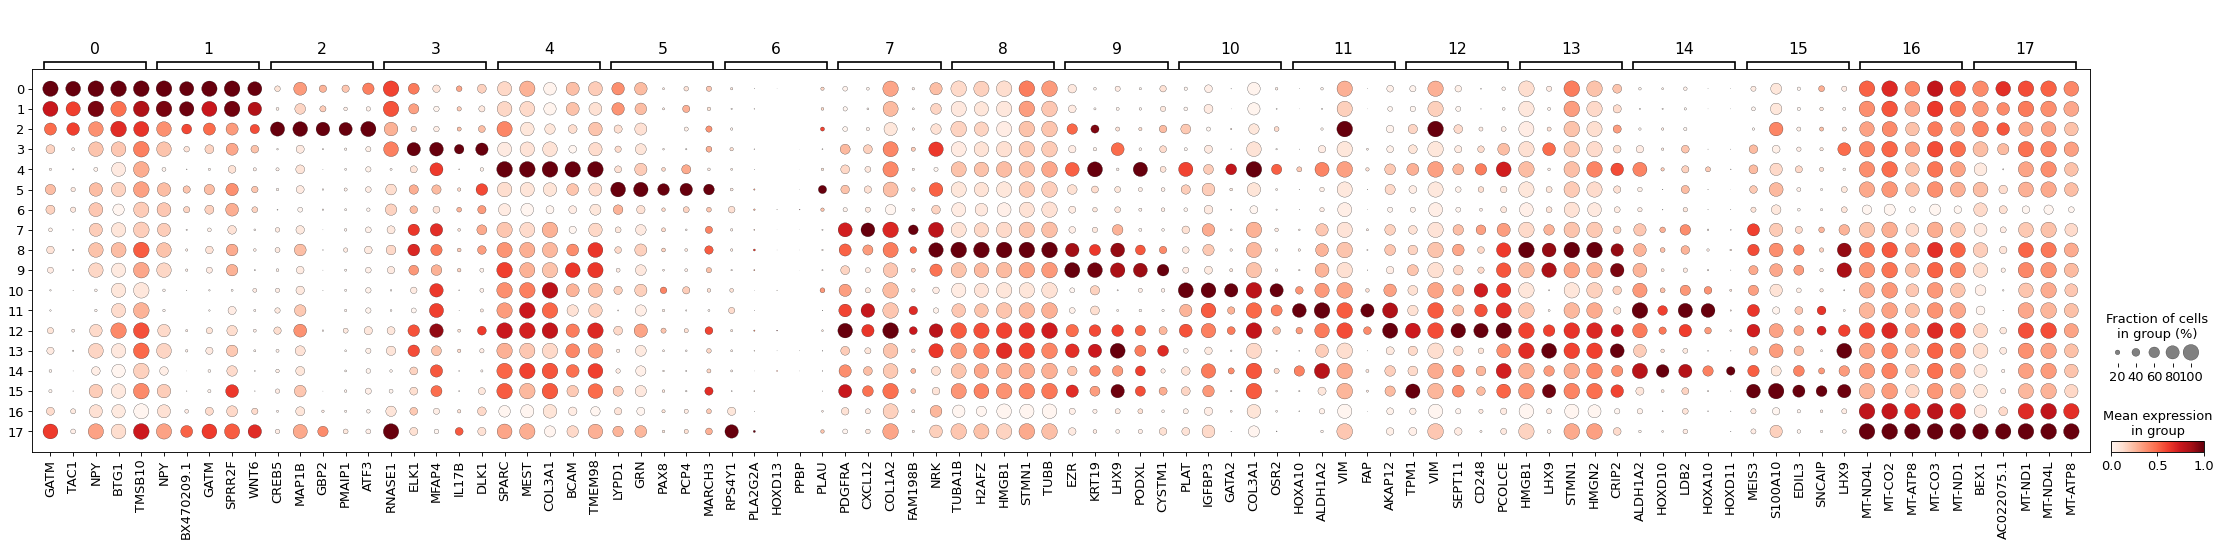

In [42]:
bdata.obs['leiden'] = adata.obs['leiden']
sc.tl.rank_genes_groups(bdata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(bdata, n_genes=5, dendrogram=False, use_raw = False, standard_scale = 'var')

In [43]:
marker_genes = {
    'mesothelial': {'LRRN4', 'UPK3B', 'KLK11'},
    'Gonadal':{'LHX9', 'GATA4', 'ARX'},
    'Supporting':{"WNT6", 'NR5A1'},
    'sKITLG': {'IL17B', 'KITLG', 'VSNL1', 'CDH7' ,'CRB1', 'THSD7A'},
    'sLGR5':{'LGR5', 'TSPAN8', 'SRY', 'EPHA4', 'CXCR4','NANOG',  'RIMS4', 'CCKBR', 'HSD17B14'},
    'granulosa':{'OSR1', 'FOXL2', "IRX3", "RDH10", 'NOTCH3'},
    'OSE':{'LHX2'},
    'Sertoli': {'SOX9', 'INHBB', 'DHH', 'AMH'},
    'sPAX8': {'PAX8'},
    'Stromal':{'DCN', 'PDGFRA', 'TCF21'},
    'Stromal_extra':{'NR2F1', 'GATA2', 'RSPO3'},
#     'Stromal_gond':{'GATA4', 'ARX'},
    'Leydig':{'INSL3', 'HHIP', 'PTCH2', 'FDX1'},
    'PGCs': {'POU5F1', 'NANOS3'},
#     'Germ Cells': {'DAZL'},
    'epithelial': {"EPCAM", "KRT19"},
    'neural': {'ASCL1'},
    'endothelial': {'PECAM1', 'CDH5'},
#     'immune': {'PTPRC'},
    'erythroid': {"GYPC", "HBA1"},
    'perivascular': {"PDGFRB", 'ACTA2'},
    'erythroid': {"GYPC", "HBA1"},
    'cycling':{'CDK1'}
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale = 'var')


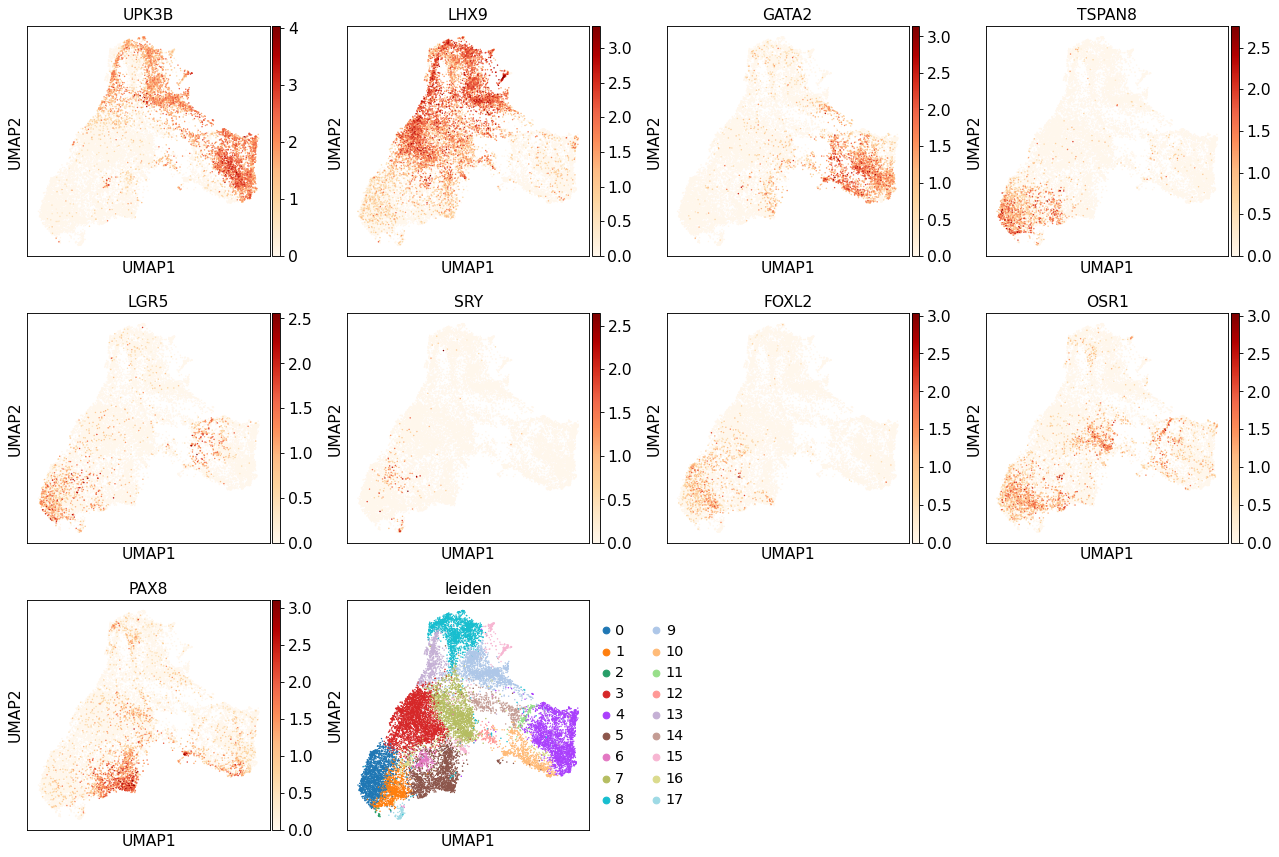

In [44]:
sc.pl.umap(
    adata,
    color=['PCW', 'scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.2
)

sc.pl.umap(
    adata,
    color=[ 'UPK3B', 'LHX9', 'GATA2','TSPAN8', 'LGR5', 'SRY', 'FOXL2', 'OSR1', 'PAX8', 'leiden'], color_map = "OrRd",
    frameon=True, ncols = 4, wspace = 0.2
)

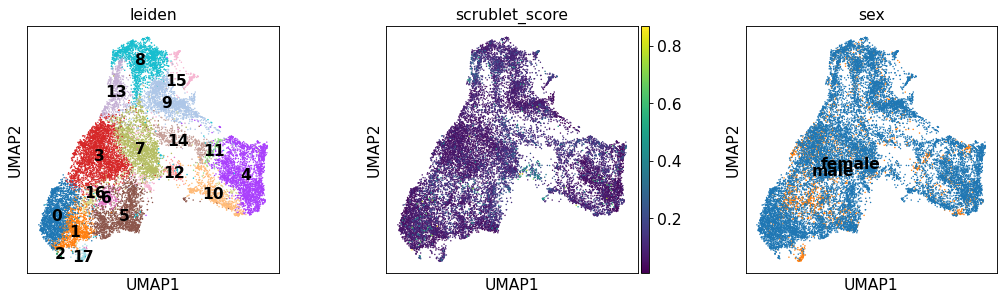

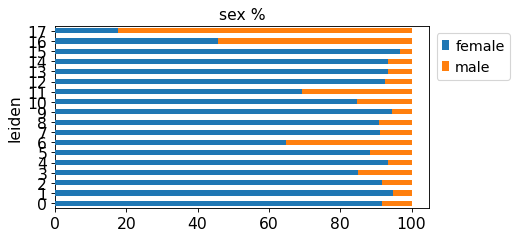

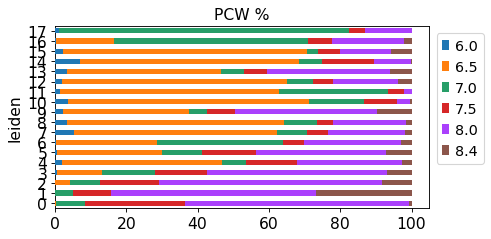

In [45]:
sc.pl.umap(
    adata,
    color=['leiden', 'scrublet_score', 'sex'], legend_loc='on data',
    frameon=True,  wspace = 0.3
)
Barplot('donor', adata, var='leiden', height=3)
Barplot('phase', adata, var='leiden', height=3)
Barplot('sex', adata, var='leiden', height=3)
Barplot('PCW', adata, var='leiden', height=3)

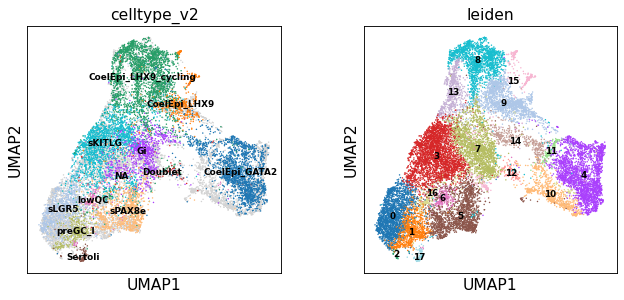

In [46]:
sc.pl.umap(
    adata,
    color=["celltype_v2", 'leiden'], ncols = 2,
    legend_loc='on data', legend_fontsize=8
)

... storing 'celltype' as categorical


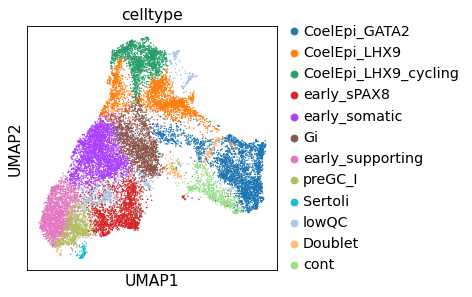

In [48]:
adata.obs['celltype'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['leiden'] == '0', 'celltype'] = 'early_supporting'
adata.obs.at[adata.obs['leiden'] == '1', 'celltype'] = 'preGC_I'
adata.obs.at[adata.obs['leiden'] == '2', 'celltype'] = 'Doublet'
adata.obs.at[adata.obs['leiden'] == '3', 'celltype'] = 'early_somatic'
adata.obs.at[adata.obs['leiden'] == '4', 'celltype'] = 'CoelEpi_GATA2'
adata.obs.at[adata.obs['leiden'] == '5', 'celltype'] = 'early_sPAX8'
adata.obs.at[adata.obs['leiden'] == '6', 'celltype'] = 'lowQC'
adata.obs.at[adata.obs['leiden'] == '7', 'celltype'] = 'Gi'
adata.obs.at[adata.obs['leiden'] == '8', 'celltype'] = 'CoelEpi_LHX9_cycling'
adata.obs.at[adata.obs['leiden'] == '9', 'celltype'] = 'CoelEpi_LHX9'
adata.obs.at[adata.obs['leiden'] == '10', 'celltype'] = 'cont'
adata.obs.at[adata.obs['leiden'] == '11', 'celltype'] = 'Doublet'
adata.obs.at[adata.obs['leiden'] == '12', 'celltype'] = 'Doublet'
adata.obs.at[adata.obs['leiden'] == '13', 'celltype'] = 'CoelEpi_LHX9'
adata.obs.at[adata.obs['leiden'] == '14', 'celltype'] = 'CoelEpi_GATA2'
adata.obs.at[adata.obs['leiden'] == '15', 'celltype'] = 'lowQC'
adata.obs.at[adata.obs['leiden'] == '16', 'celltype'] = 'lowQC'
adata.obs.at[adata.obs['leiden'] == '17', 'celltype'] = 'Sertoli'
set(adata.obs['celltype'])
sc.pl.umap(adata, color=['celltype'])
adata.obs['celltype'].cat.reorder_categories(['CoelEpi_GATA2', 'CoelEpi_LHX9', 'CoelEpi_LHX9_cycling',  'early_sPAX8', 
                                             'early_somatic', 'Gi',  'early_supporting',
                                              'preGC_I',  'Sertoli',  'lowQC', 'Doublet', 'cont'], inplace=True)

sc.pl.umap(adata, color=['celltype'])
sc.pl.umap(adata, color=['celltype_v2', 'celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8)

In [49]:
adata.obs.to_csv(path_to_gonads+'/FCA-gonads_somaticEarly_annotated.csv')
adata.write(path_to_gonads+'/FCA-gonads_somaticEarly_annotated.h5ad')

In [50]:
bdata.obs['celltype'] = adata.obs['celltype']
sc.tl.rank_genes_groups(adata, groupby='celltype', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')

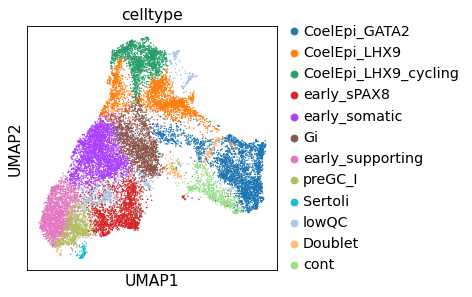

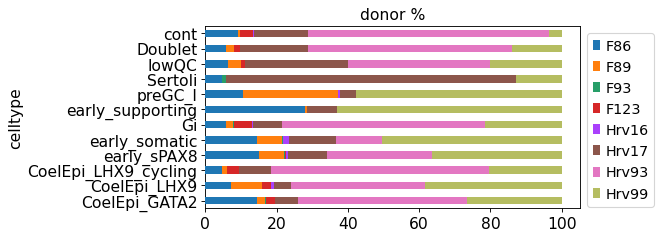

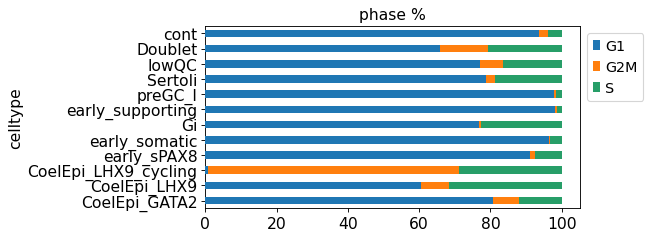

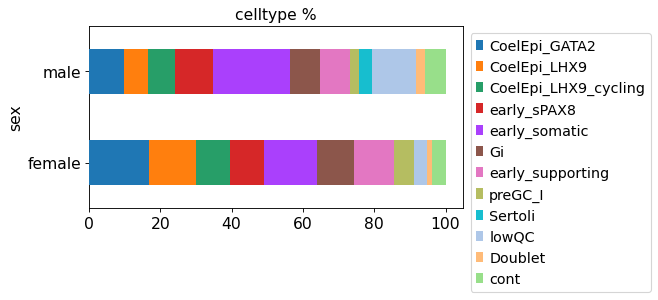

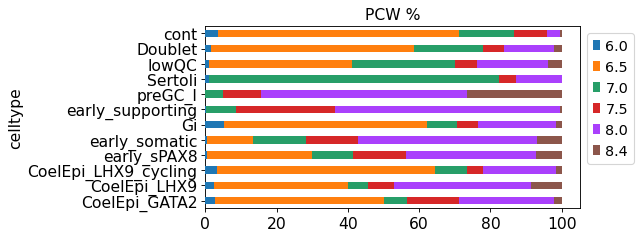

In [51]:
sc.pl.umap(adata, color=['donor'], groups = [ 'Hrv17'])
sc.pl.umap(adata, color=['celltype'])

Barplot('donor', adata, var='celltype', height=3)
Barplot('phase', adata, var='celltype', height=3)
Barplot('sex', adata, var='celltype', height=3)
Barplot('celltype', adata, var='sex', height=3)
Barplot('PCW', adata, var='celltype', height=3)

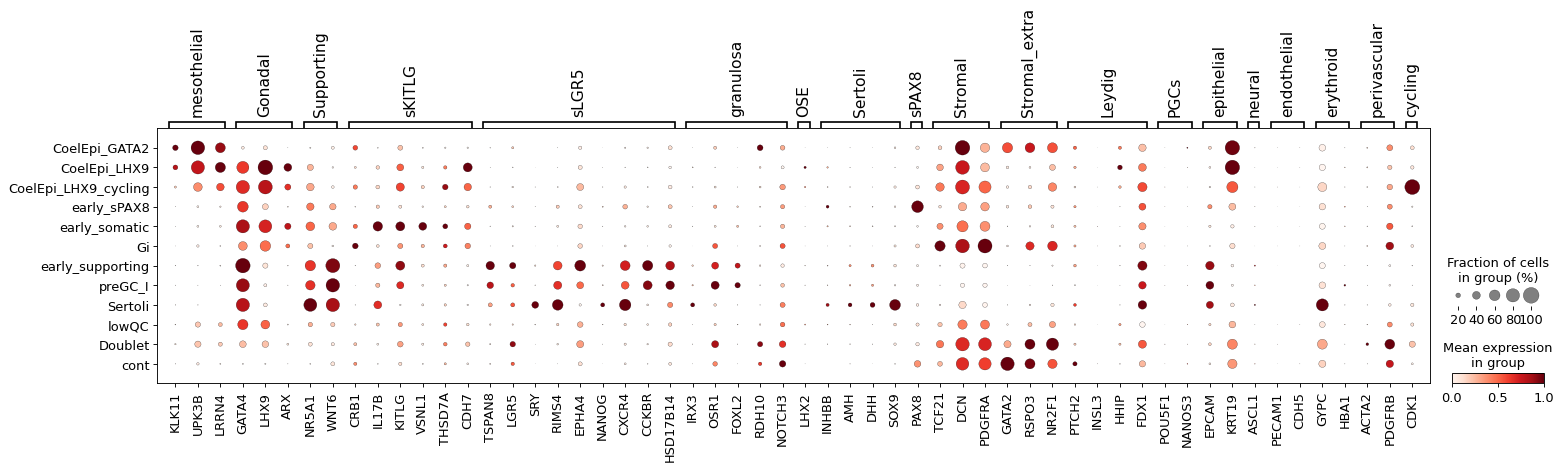

In [52]:
sc.pl.dotplot(adata, marker_genes, groupby='celltype', standard_scale = 'var')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sex_celltype' as categorical


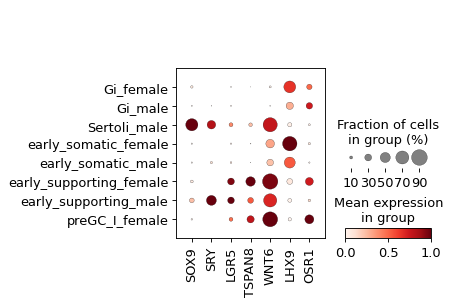

In [53]:
adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)
XX = adata[[ i in ['Sertoli', 'early_somatic', 'early_supporting', 'preGC_I', 'Gi'] for i in adata.obs['celltype']]]
XX = XX[[ i not in ['Sertoli_female', 'preGC_I_male'] for i in XX.obs['sex_celltype']]]
sc.pl.dotplot(XX, ['SOX9', 'SRY', 'LGR5', 'TSPAN8', 'WNT6', 'LHX9', 'OSR1'], groupby='sex_celltype', standard_scale = 'var')

In [54]:
sc.pl.umap(
    adata[[i in 'Sertoli' for i in adata.obs.celltype ]],
    color=["leiden", 'sex'], ncols = 2,
    legend_loc='on data', legend_fontsize=8
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'sex_celltype' as categorical


... storing 'sex_celltype' as categorical


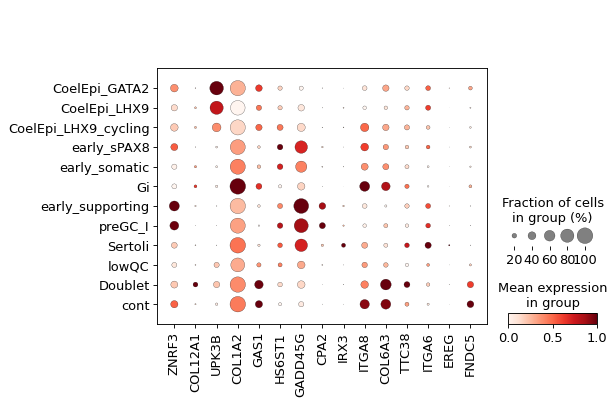

In [55]:
markers_mmu = ['Znrf3', 'Col12a1', 'Upk3b', 'Col1a2', 'Gas1', 'Hs6st1', 'Gadd45g', 'Cpa2', 'Irx3', 'Itga8', 'Col6a3', 'Ttc38', 'Itga6', 'Ereg', 'Fndc5']
markers_mmu = [ i.upper() for i in markers_mmu]

sc.pl.dotplot(adata, markers_mmu, groupby='celltype', standard_scale = 'var')